In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
img_width = 128
img_height = 128
img_channels = 1

# Custom for a specific Problem

## Importing the Libraries

In [5]:
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

## Setting the path

In [6]:


train_path = "D:\\Data sets\\DRIVE\\training"
train_ids = next(os.walk("processed"))[2]
gt_ids = next(os.walk(train_path + "\\1st_manual"))[2]

# test_ids = next(os.walk(test_path + "\images"))[2]

In [7]:
train_ids[:5], gt_ids[:5]#, test_ids[:5] 

(['Train21.tif', 'Train22.tif', 'Train23.tif', 'Train24.tif', 'Train25.tif'],
 ['21_manual1.gif',
  '22_manual1.gif',
  '23_manual1.gif',
  '24_manual1.gif',
  '25_manual1.gif'])

## Setting the train and test 

In [8]:
import gif2numpy
import cv2

In [10]:
thresh = 0

In [11]:
def gtImageDis(gt_path):
    frames, exts, image_specs = gif2numpy.convert(gt_path)
    frames = np.array(frames)
    labeled_img = frames.reshape(584, 565,3)
    labeled_img_dis = cv2.cvtColor(labeled_img, cv2.COLOR_BGR2GRAY)
#     binary = labeled_img_dis > thresh
    return labeled_img_dis

In [23]:
def imgTransformed(img):
    top, bottom = [28] * 2
    left, right = [37,38]
    imgPad = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value= 0)
    return imgPad

In [30]:
X_train = np.zeros((len(train_ids)*41, img_height, img_width, img_channels), dtype=np.uint8)
Y_train = np.zeros((len(train_ids)*41, img_height, img_width), dtype=np.uint8)

In [31]:
k = 0

In [32]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path ="processed\\" +id_
    img = imread(path,plugin="pil")[:,:]  
    imgTrans = imgTransformed(img)
    
#     X_train[n] = img  #Fill empty X_train with values from img
            
    gt_path = train_path+ "\\1st_manual\\" + gt_ids[n]
    gt_img = gtImageDis(gt_path)
    gtTrans = imgTransformed(gt_img)
#     gt_img = resize(gt_img, (img_height, img_width), mode='constant', preserve_range=True)
#     Y_train[n] = gt_img
    
################################################# Type 1 Slicing  ###################################################
    top = left = 0
    bottom = right = 128

    for i in range(5):
        for j in range(5):
            cropImg = imgTrans[top:bottom,left:right]
            X_train[k] =  cropImg.reshape(128,128,1)
            
            cropGT = gtTrans[top:bottom,left:right]
            Y_train[k] =  cropGT
            
            k += 1
            left += 128
            right += 128
        left = 0
        right = 128
        top += 128
        bottom += 128
    
################################################# Type 2 Slicing  ###################################################
    top = left = 63
    bottom = right = 191

    for i in range(4):
        for j in range(4):
            cropImg2 = imgTrans[top:bottom,left:right]
            X_train[k] =  cropImg2.reshape(128,128,1)

            cropGT2 = gtTrans[top:bottom,left:right]
            Y_train[k] =  cropGT2

            k += 1
            left += 128
            right += 128
        left = 63
        right = 191
        top += 128
        bottom += 128
    
    
    
print("Done")

  0%|          | 0/20 [00:00<?, ?it/s]

Resizing training images and masks


100%|██████████| 20/20 [00:05<00:00,  3.62it/s]

Done


In [34]:
X_train.shape

(820, 128, 128, 1)

In [35]:
unique, counts = np.unique(Y_train, return_counts=True)
dict(zip(unique, counts))

{0: 12302035, 255: 1132845}

In [15]:
X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)
sizes_test = []

In [16]:
# test images
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_path +"\\images\\" +id_
    img = imread(path,plugin="pil")[:,:,:img_channels]  
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)

    X_test[n] = img

print('Done!')

  0%|          | 0/20 [00:00<?, ?it/s]

Resizing test images


100%|██████████| 20/20 [00:01<00:00, 15.10it/s]

Done!


## Preview of the Work Done Till Now

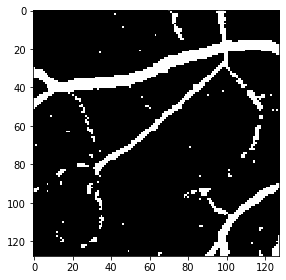

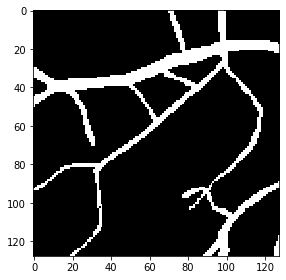

In [38]:
image_x = random.randint(0, len(train_ids)*41)
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

# The Model

In [39]:
norm_inputs = tf.keras.layers.Input((img_height, img_width,1))
inputs = tf.keras.layers.Lambda(lambda x: x/255)(norm_inputs)

In [40]:
inputs

<KerasTensor: shape=(None, 128, 128, 1) dtype=float32 (created by layer 'lambda')>

## Contraction Path

In [41]:
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(c1)
p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

In [42]:
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(c2)
p2 = tf.keras.layers.MaxPool2D((2,2))(c2)

In [43]:
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(c3)
p3 = tf.keras.layers.MaxPool2D((2,2))(c3)

In [44]:
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(p3)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(c4)
p4 = tf.keras.layers.MaxPool2D((2,2))(c4)

In [45]:
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(p4)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same' )(c5)
p5 = tf.keras.layers.MaxPool2D((2,2))(c5)

## Expansive Path

In [46]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

In [47]:
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

In [48]:
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

In [49]:
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

## Model Compilation

In [50]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [51]:
model = tf.keras.Model(inputs=[norm_inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

## Model Check Point

In [52]:
checkpointer = tf.keras.callbacks.ModelCheckpoint("u_net_model.h5", verbose=1, save_best_only=True)

In [53]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir = 'logs')
]

In [54]:
es = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
tboard = tf.keras.callbacks.TensorBoard(log_dir = 'logs')

# Results

In [55]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=25, callbacks=callbacks)

Epoch 1/25
93/93 [==============================] - 41s 88ms/step - loss: -308.1498 - accuracy: 0.0023 - val_loss: -291.8872 - val_accuracy: 0.0000e+00 - accuracy: 0.00
Epoch 2/25
93/93 [==============================] - 6s 63ms/step - loss: -314.9441 - accuracy: 0.0000e+00 - val_loss: -291.8872 - val_accuracy: 0.0000e+00ss: -324.4734 - 
Epoch 3/25
93/93 [==============================] - 6s 62ms/step - loss: -314.9441 - accuracy: 0.0000e+00 - val_loss: -291.8872 - val_accuracy: 0.0000e+00ss: -315.2137 - accuracy: 0.00 - ETA: 3s - loss: -312.9878 - - ETA


In [56]:
#idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0])], verbose=1)
# preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0).astype(np.uint8)
# preds_test_t = (preds_test > 0).astype(np.uint8)

26/26 [==============================] - 5s 83ms/step


## Sanity check on some random training samples

D:\ana\envs\tensor\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


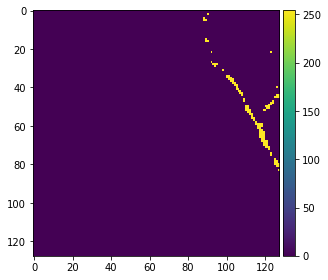

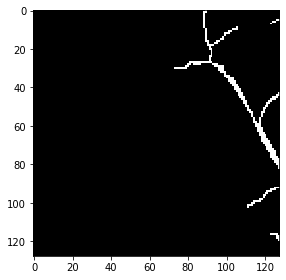

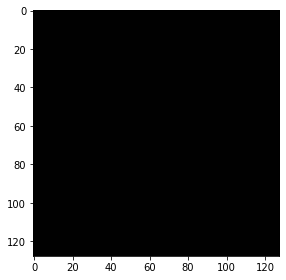

In [57]:

ix = random.randint(0, len(preds_train_t)-1)
imshow(X_train[ix])
plt.show()
imshow(Y_train[ix])
plt.show()
imshow(np.squeeze(preds_train_t[ix]), cmap = "gray")
plt.show()

## Sanity check on some random testing samples

In [58]:
ix = random.randint(0, len(preds_test_t) - 1)
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

NameError: name 'preds_test_t' is not defined